# Non-Linear Modeling


이 실습에서는 본 장에서 다룬 다양한 비선형 회귀 기법을 적용합니다
예제로는 `Wage` 데이터셋을 사용합니다.


In [ ]:
# !pip install ISLP

In [2]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

In [ ]:
# !pip install pygam

In [3]:
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)

from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)


### Polynomial Regression and Step Functions

In [4]:
# 데이터 불러오기
Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']

실습에서는 대부분 wage 변수를 종속변수(y)로 사용합니다.

In [5]:
# age에 대해 4차 다항식 회귀 모델을 학습합니다.
poly_age = MS([poly('age', degree=4)]).fit(Wage) # 절편 X 
M = sm.OLS(y, poly_age.transform(Wage)).fit() # 절편 O
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


age에 대한 예측값을 계산하기 위한 그리드(grid)를 생성합니다.

In [6]:
age_grid = np.linspace(age.min(),
                       age.max(),
                       100)

In [7]:
age_df = pd.DataFrame({'age': age_grid})
print(age_df.head(), '\n',age_df.tail() )

         age
0  18.000000
1  18.626263
2  19.252525
3  19.878788
4  20.505051 
           age
95  77.494949
96  78.121212
97  78.747475
98  79.373737
99  80.000000


데이터와 4차 다항식으로 적합된 곡선을 함께 시각화하고자 합니다.
비슷한 그래프를 여러 번 그릴 예정이므로, 이 작업을 수행하는 공통 함수를 먼저 정의하겠습니다.

이 함수는 다음 세 가지를 입력으로 받습니다:

변환기 또는 모델 사양(basis)

예측을 수행할 age 그리드 (age_df)

그래프 제목 (title)

해당 함수는 주어진 기준에 따라 모델을 적합하고,
**예측 곡선(predicted curve)**과 **95% 신뢰구간(confidence bands)**을 함께 시각화합니다.
다양한 변환기(basis) 예: 다항식, 스플라인 등을 이 함수에 적용할 수 있습니다.

In [8]:
def plot_wage_fit(age_df, basis, title):
    # 주어진 변환기(basis)를 사용하여 전체 Wage 데이터에 대해 설계 행렬 X 생성
    X = basis.transform(Wage)
    
    # 예측을 원하는 age 그리드(age_df)에 대해서도 동일한 방식으로 변환 수행
    Xnew = basis.transform(age_df)
    
    # 선형 회귀 모델 적합 (OLS: 최소제곱법)
    M = sm.OLS(y, X).fit()
    
    # 새 입력(age_df)에 대한 예측값 및 신뢰구간 계산
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)  # 95% 신뢰구간

    # 그래프 준비: 크기 지정
    fig, ax = subplots(figsize=(8, 8))

    # 원본 데이터 산점도 시각화 (회색 점, 투명도 0.5)
    ax.scatter(age, y, facecolor='gray', alpha=0.5)

    # 예측값(predicted_mean)과 신뢰구간(bands) 각각을 선으로 그림
    for val, ls in zip(
        [preds.predicted_mean, bands[:, 0], bands[:, 1]],  # 예측값, 하한, 상한
        ['b', 'r--', 'r--']  # 파란 실선, 빨간 점선들
    ):
        ax.plot(age_df.values, val, ls, linewidth=3)

    # 그래프 제목 및 축 레이블 설정
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylabel('Wage', fontsize=20)

    # Axes 객체 반환 (그래프 조작/저장 가능)
    return ax


<Axes: title={'center': 'Degree-4 Polynomial'}, xlabel='Age', ylabel='Wage'>

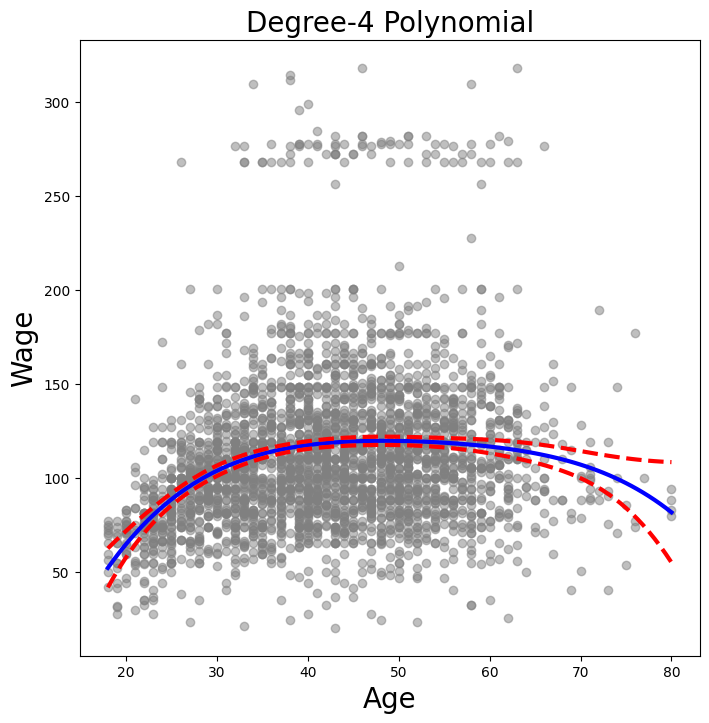

In [9]:
# poly_age -> 4차 다항회귀 모델 객체
plot_wage_fit(age_df, 
              poly_age,
              'Degree-4 Polynomial')

### 다항 회귀 차수 선택하기

1차(선형)부터 5차까지의 다항 회귀 모델을 차례대로 적합하고,
wage와 age 사이의 관계를 설명하는 데 가장 단순하면서 충분한 모델이 무엇인지 판단해보겠습니다.
이를 위해 anova_lm() 함수를 사용합니다. 이 함수는 일련의 ANOVA (분산분석) 검정을 수행합니다.

In [ ]:
models = [MS([poly('age', degree=d)]) 
          for d in range(1, 6)] # 1차부터 5차까지 다항 회귀 모델 적합
Xs = [model.fit_transform(Wage) for model in models] 
anova_lm(*[sm.OLS(y, X_).fit()
           for X_ in Xs]) # *는 anova_lm이 여러 개의 인자를 받을 수 있기 때문에 한번에 다 넣을 수 있습니다.


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


ANOVA 결과 해석(주의 permutation이 아님, 순차적으로 적용된거임)

models_0(1차) vs models_1(2차) 비교: p값이 거의 0 → 선형 모델은 부적절   
models_1(2차) vs models_2(3차) 비교: p = 0.0017 → 2차도 부적절   
models_2 vs models_3(4차): p ≈ 0.05 → 경계적   
models_3 vs models_4(5차): p = 0.37 → 5차는 불필요   


→ 따라서 3차(cubic) 혹은 4차(quartic) 모델이 가장 적절하며,   
이보다 단순하거나 복잡한 모델은 근거가 약합니다.



education을 공통으로 포함한 후,
age에 대해 1차~3차 다항식을 사용한 세 모델을 비교합니다.

In [11]:
models = [MS(['education', poly('age', degree=d)])
          for d in range(1, 4)]
XEs = [model.fit_transform(Wage)
       for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in XEs])


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2997.0,3.902335e+06,0.0,NaN,NaN,NaN
1,2996.0,3.759472e+06,1.0,142862.701185,113.991883,3.838075e-26
2,2995.0,3.753546e+06,1.0,5926.207070,4.728593,2.974318e-02


교차검증으로 차수 선택도 가능함   
이러한 가설 검정(ANOVA) 외에도,   
[교차검증(cross-validation)]을 사용하여 다항식 차수를 선택할 수도 있습니다

### Logistic multiple regression

연간 수입이 $250,000 이상인지를 예측하는 로지스틱 회귀 모델을 학습합니다.

In [12]:
X = poly_age.transform(Wage)
high_earn = Wage['high_earn'] = y > 250 # 이제는 target value가 0또는 1로 만든 모습
glm = sm.GLM(y > 250,
             X,
             family=sm.families.Binomial())
B = glm.fit()
summarize(B)


,coef,std err,z,P>|z|
intercept,-4.3012,0.345,-12.457,0.000
"poly(age, degree=4)[0]",71.9642,26.133,2.754,0.006
"poly(age, degree=4)[1]",-85.7729,35.929,-2.387,0.017
"poly(age, degree=4)[2]",34.1626,19.697,1.734,0.083
"poly(age, degree=4)[3]",-47.4008,24.105,-1.966,0.049


예측 및 신뢰구간 계산

In [13]:
newX = poly_age.transform(age_df)
preds = B.get_prediction(newX)
bands = preds.conf_int(alpha=0.05)

시각화

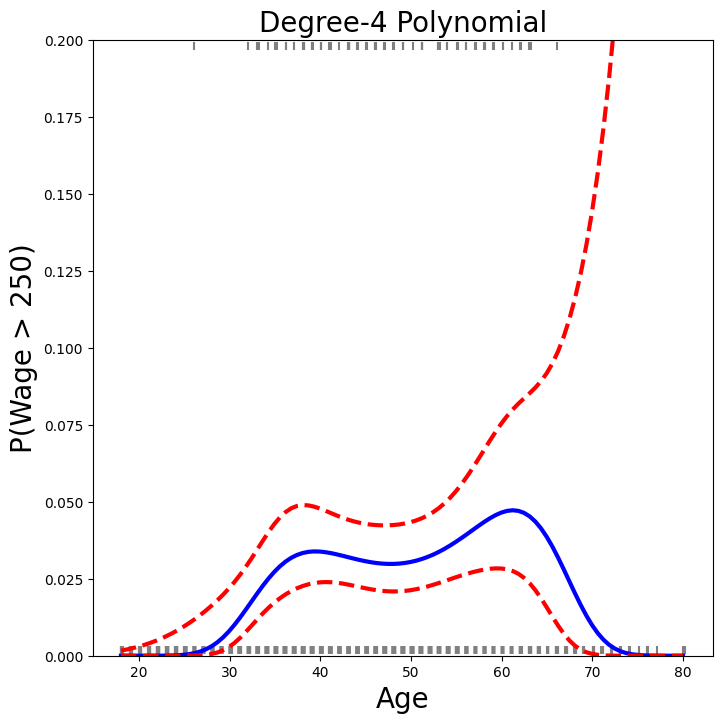

In [14]:
fig, ax = subplots(figsize=(8,8))
rng = np.random.default_rng(0)

ax.scatter(age +
           0.2 * rng.uniform(size=y.shape[0]),
           np.where(high_earn, 0.198, 0.002), # 데이터 시각화: 고소득자는 위에, 아닌 사람은 아래에 회색 | 표시
           fc='gray',
           marker='|')

# 예측값과 신뢰구간 그리기
for val, ls in zip([preds.predicted_mean,
                  bands[:,0],
                  bands[:,1]],
                 ['b','r--','r--']):
    ax.plot(age_df.values, val, ls, linewidth=3)
ax.set_title('Degree-4 Polynomial', fontsize=20)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylim([0,0.2])
ax.set_ylabel('P(Wage > 250)', fontsize=20);


### Step function

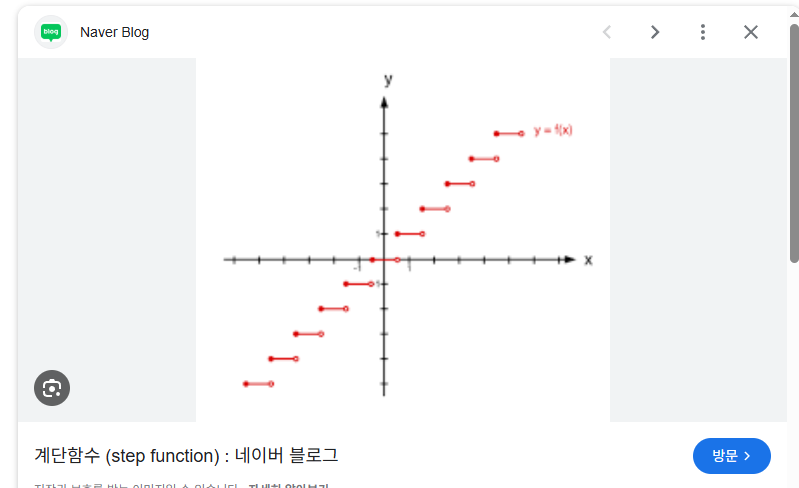

In [15]:
# age를 사분위수(quantile) 기준으로 분할한 뒤, 더미 변수(dummy variable)로 변환합니다.
cut_age = pd.qcut(age, 4)
summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())


,coef,std err,t,P>|t|
"(17.999, 33.75]",94.1584,1.478,63.692,0.0
"(33.75, 42.0]",116.6608,1.470,79.385,0.0
"(42.0, 51.0]",119.1887,1.416,84.147,0.0
"(51.0, 80.0]",116.5717,1.559,74.751,0.0


/tmp/ipykernel_2950396/3201309174.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_wage_per_bin = y.groupby(cut_age).mean().values


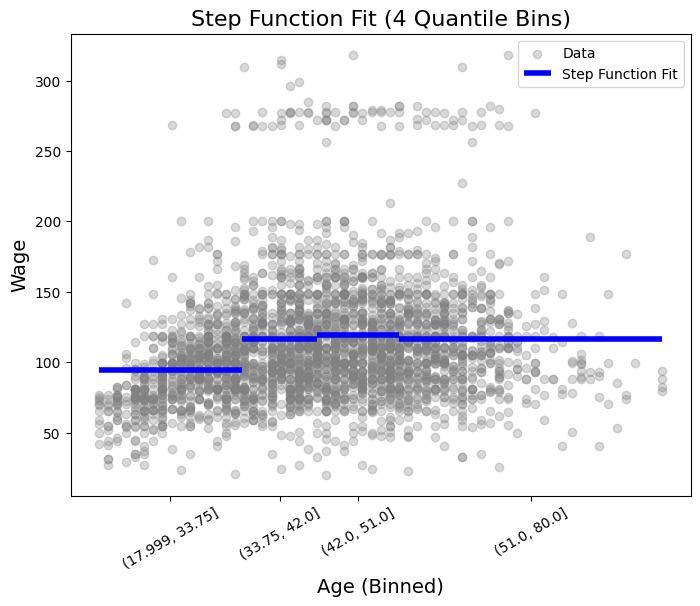

In [16]:
# 구간 이름 추출
cut_age = pd.qcut(age, 4)
X_step = pd.get_dummies(cut_age)
model = sm.OLS(y, X_step).fit()

# 각 구간별 평균 예측값
group_means = model.predict(X_step)

# 각 구간의 중앙값 또는 범위 추출 (plot 용 x좌표)
bins = cut_age.cat.categories  # Interval 객체 리스트
bin_centers = [(interval.left + interval.right) / 2 for interval in bins]
bin_labels = [str(interval) for interval in bins]

# 구간별 평균 wage 계산
mean_wage_per_bin = y.groupby(cut_age).mean().values

# 시각화
fig, ax = subplots(figsize=(8, 6))
ax.scatter(age, y, alpha=0.3, color='gray', label='Data')
ax.hlines(mean_wage_per_bin, [b.left for b in bins], [b.right for b in bins],
          colors='blue', linewidth=4, label='Step Function Fit')

# x축에 구간 중심 표시
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels, rotation=30)
ax.set_xlabel('Age (Binned)', fontsize=14)
ax.set_ylabel('Wage', fontsize=14)
ax.set_title('Step Function Fit (4 Quantile Bins)', fontsize=16)
ax.legend();


## Splines


B-spline 기저 함수 구성   
아래는 내부 결절점(knots)을 지정하여 B-spline을 구성하는 예시입니다

In [17]:
bs_ = BSpline(internal_knots=[25,40,60], intercept=True).fit(age)
bs_age = bs_.transform(age)
bs_age.shape

(3000, 7)

결과는 열이 7개인 행렬이며,
이는 3개의 내부 결절점과 함께 cubic-spline basis를 사용했을 때의 예상 결과입니다.    
B-spline 모델 적합
앞서 poly()와 Poly()의 관계처럼,
bs()는 BSpline()을 모델에 편하게 삽입할 수 있도록 도와주는 helper입니다.

In [18]:
bs_age = MS([bs('age', internal_knots=[25,40,60])])
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
"bs(age, internal_knots=[25, 40, 60])[0]",3.9805,12.538,0.317,0.751
"bs(age, internal_knots=[25, 40, 60])[1]",44.6310,9.626,4.636,0.000
"bs(age, internal_knots=[25, 40, 60])[2]",62.8388,10.755,5.843,0.000
"bs(age, internal_knots=[25, 40, 60])[3]",55.9908,10.706,5.230,0.000
"bs(age, internal_knots=[25, 40, 60])[4]",50.6881,14.402,3.520,0.000
"bs(age, internal_knots=[25, 40, 60])[5]",16.6061,19.126,0.868,0.385


이때 자동 생성된 열 이름이 다소 복잡하게 출력될 수 있으므로,
name 인자를 통해 이름을 지정할 수 있습니다

In [19]:
bs_age = MS([bs('age',
                internal_knots=[25,40,60],
                name='bs(age)')]) # 여기선 상수항 X
Xbs = bs_age.fit_transform(Wage) # 여기에서 상수항이 추가됨
M = sm.OLS(y, Xbs).fit()
summarize(M)


,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
bs(age)[0],3.9805,12.538,0.317,0.751
bs(age)[1],44.6310,9.626,4.636,0.000
bs(age)[2],62.8388,10.755,5.843,0.000
bs(age)[3],55.9908,10.706,5.230,0.000
bs(age)[4],50.6881,14.402,3.520,0.000
bs(age)[5],16.6061,19.126,0.868,0.385


계수는 총 6개가 출력됩니다.   
이는 bs() 기본 설정이 intercept=False이기 때문에,   
내부적으로 1개의 기저 함수를 제거하여 상수항과 중복을 방지하기 때문입니다.   

In [20]:
np.quantile(a = age ,q=[.25,.5, .75])

array([33.75, 42.  , 51.  ])

In [21]:
# 자유도(df)로 복잡도 지정
#  knots을 직접 지정하는 대신, 자유도(df)를 통해 스플라인의 복잡도를 지정할 수도 있습니다.
# 예를 들어 df=6을 지정하면, B-spline은 데이터의 사분위수에 따라 knots을 자동 선택합니다.

# df가 6일때 왜 4분위수? ->  (cubic; 자유도 절편 X, 3차) 3 + x = 6 -> x = 3
# 데이터를 3개로 나누려면 4분위수  

BSpline(df=6).fit(age).internal_knots_

array([33.75, 42.  , 51.  ])

In [21]:
# Natural Spline 이용하기 위해서는 ns() 이용용
ns_age = MS([ns('age', df=5)]).fit(Wage)
M_ns = sm.OLS(y, ns_age.transform(Wage)).fit()
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,60.4752,4.708,12.844,0.000
"ns(age, df=5)[0]",61.5267,4.709,13.065,0.000
"ns(age, df=5)[1]",55.6912,5.717,9.741,0.000
"ns(age, df=5)[2]",46.8184,4.948,9.463,0.000
"ns(age, df=5)[3]",83.2036,11.918,6.982,0.000
"ns(age, df=5)[4]",6.8770,9.484,0.725,0.468


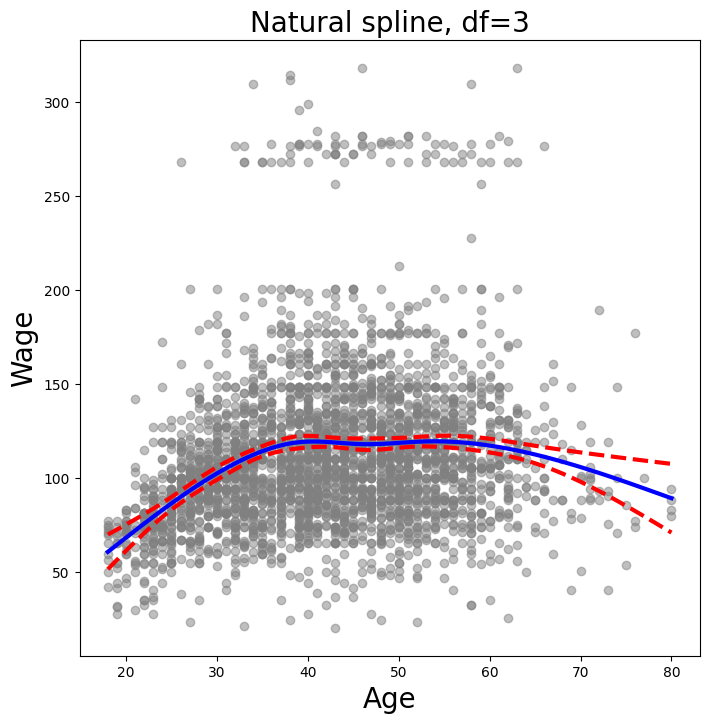

In [22]:
plot_wage_fit(age_df,
              ns_age,
              'Natural spline, df=3');

## Smoothing Splines and GAMs
Smoothing spline은 GAM의 특수한 형태로,
**제곱 오차 손실(squared-error loss)**과 하나의 특성(feature)을 사용하는 경우에 해당합니다.

In [23]:
X_age = np.asarray(age).reshape((-1,1)) # LinearGAM의 input 형태가 numpy array 형태임.

In [26]:
gam = LinearGAM(s_gam(0, lam=0.6)) # (lambda; 패널티 term) 
gam.fit(X_age, y) 
# 에러 :AttributeError: 'csr_array' object has no attribute 'A'
# pip install "scipy<1.14.0" scipy의 버전을 낮춰야합니다
# https://github.com/saezlab/decoupler-py/issues/139 

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

λ(lam) 값 변화에 따른 스무딩 결과 비교   
np.logspace() 함수는 np.linspace()와 유사하지만, 로그 스케일로 값을 고르게 분포시킵니다.    
아래는 λ 값을 0.01 ~ 1e6 까지 변화시키면서 적합 결과를 시각화한 예입니다.   

0.01
1.0
100.0
10000.0
1000000.0


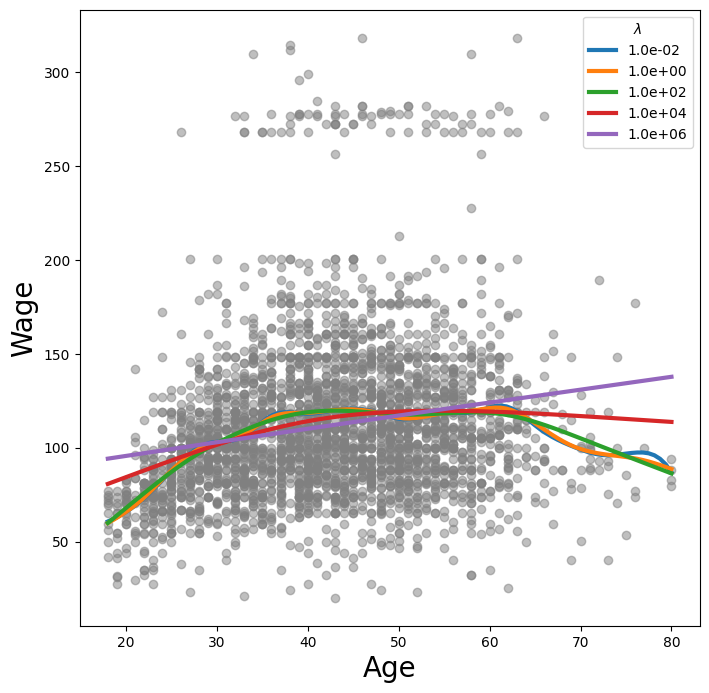

In [27]:
fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
for lam in np.logspace(-2, 6, 5):
    print(lam)
    gam = LinearGAM(s_gam(0, lam=lam)).fit(X_age, y)
    ax.plot(age_grid,
            gam.predict(age_grid),
            label='{:.1e}'.format(lam),
            linewidth=3)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='$\lambda$');


최적의 패널티 term을 찾기 위해서 grid search도 가능

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


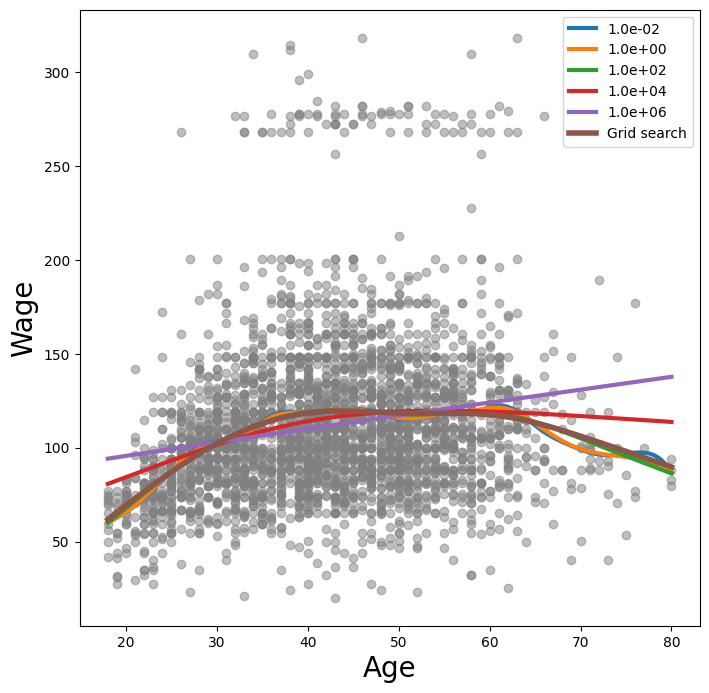

In [28]:
gam_opt = gam.gridsearch(X_age, y)
ax.plot(age_grid,
        gam_opt.predict(age_grid),
        label='Grid search',
        linewidth=4)
ax.legend()
fig


자유도(df) 변화에 따른 예측 곡선 비교   
아래 그래프에서는 원하는 자유도(df)를 1, 3, 4, 8, 15로 설정하고,   
이에 대응하는 λ 값을 추정하여 각각 적합합니다.   

df=1인 경우는 단순 선형 회귀와 동일합니다.

In [29]:
age_term = gam.terms[0]  # age에 대한 smoothing term
lam_4 = approx_lam(X_age, age_term, 4)
age_term.lam = lam_4
degrees_of_freedom(X_age, age_term)  # 실제 df 확인

4.000000100000288

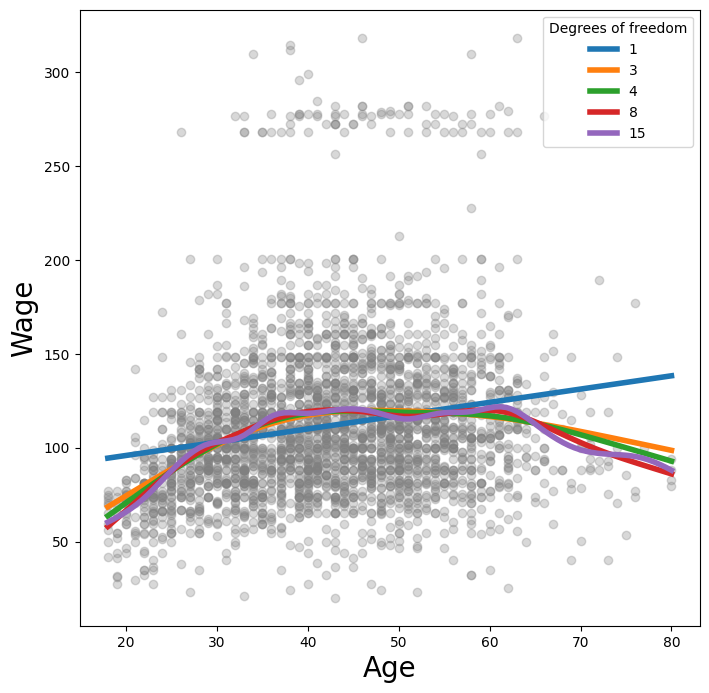

In [30]:
fig, ax = subplots(figsize=(8,8))
ax.scatter(X_age,
           y,
           facecolor='gray',
           alpha=0.3)
for df in [1,3,4,8,15]:
    lam = approx_lam(X_age, age_term, df+1)
    age_term.lam = lam
    gam.fit(X_age, y)
    ax.plot(age_grid,
            gam.predict(age_grid),
            label='{:d}'.format(df),
            linewidth=4)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='Degrees of freedom');
# 자유도 클수록 -> 데이터에 민감하게 반응하구나~


# HW (7장)

프로젝트 데이터에서 다항식 기반 로지스틱 회귀를 이용하여 `난자 기증자 나이`가 `임신 성공 확률`에 영향을 주는지를 분석하고,   
왜 유의/유의하지 않은 결과가 나왔는지 확인하기 위해 실제값과 모델의 예측 확률 곡선과 신뢰구간을 시각화하여 분석하세요.

In [31]:
# 데이터 불러오기

import pandas as pd
import os
import re
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)

data_dir = os.path.join('/home/stat/KYH/dacon_6/SML_project', 'data')
# 전처리
train = pd.read_csv(os.path.join(data_dir, 'train.csv'),encoding='cp949').drop(columns='ID').dropna()
train = train[train['난자 기증자 나이'] != '알 수 없음'].copy()

In [35]:
def age_to_numeric(x):

    numbers = list(map(int, re.findall(r'\d+', x))) # 문자열 내의 모든 숫자 추출
    
    # 하나만 있으면 그대로, 두 개 이상이면 평균
    if len(numbers) == 1:
        return numbers[0]
    else:
        return np.mean(numbers)

In [36]:
train['난자 나이 수치'] = train['난자 기증자 나이'].apply(age_to_numeric)

In [37]:
poly_age = MS([poly('난자 나이 수치', degree=4)]).fit(train)
X = poly_age.transform(train) # 디자인 행렬
y = train['임신 성공 확률']     # target value